# 量化策略回测框架 - ConvLSTM模型集成（因子筛选版）

In [1]:
# --- 必要的库导入 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
from pandas.tseries.offsets import Week
from tabulate import tabulate
from colorama import Fore, Style, Back
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
import pickle
from pathlib import Path
import warnings
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, BatchNormalization, Flatten, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report
import gc  # 用于内存管理

# 忽略Pandas在特定操作中可能产生的无害警告
warnings.filterwarnings('ignore', category=UserWarning)

# 配置日志输出格式
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# 设置绘图风格
plt.style.use('seaborn-v0_8-darkgrid')

2025-08-07 22:31:50.449466: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-07 22:31:50.490362: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-07 22:31:50.815792: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-07 22:31:51.090423: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754577111.314997  780332 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754577111.38

---
## 因子筛选模块

In [2]:
def filter_factors(factor_data, close_prices, min_ic=0.01, min_rank_ic=0.01):
    """
    使用IC和Rank_IC指标筛选优质因子
    
    参数:
    - factor_data: 因子数据DataFrame
    - close_prices: 收盘价序列
    - min_ic: IC最小阈值
    - min_rank_ic: Rank_IC最小阈值
    
    返回:
    - 筛选后的因子列表
    """
    logging.info("🔍 开始因子筛选...")
    
    # 1. 选择所有特征因子
    feature_columns = [col for col in factor_data.columns 
                      if col.startswith('ret') or col.startswith('c_chu') or col.startswith('c_hide')]
    
    # 2. 计算未来10期收益率
    future_returns = np.log(close_prices).diff(10).shift(-10)
    
    # 3. 计算每个因子的IC和Rank_IC
    ic_values = []
    rank_ic_values = []
    
    for col in feature_columns:
        # 获取因子值，填充缺失值
        factor_vals = factor_data[col].fillna(method='ffill').fillna(0)
        
        # 对齐数据，移除无效索引
        valid_idx = future_returns.notna() & factor_vals.notna()
        factor_vals = factor_vals[valid_idx]
        future_ret = future_returns[valid_idx]
        
        # 计算IC（信息系数）
        ic = factor_vals.corr(future_ret)
        
        # 计算Rank IC（秩信息系数）
        rank_ic = factor_vals.rank(pct=True).corr(future_ret.rank(pct=True))
        
        ic_values.append(ic)
        rank_ic_values.append(rank_ic)
    
    # 创建因子评估DataFrame
    factor_eval = pd.DataFrame({
        'factor': feature_columns,
        'IC': ic_values,
        'Rank_IC': rank_ic_values
    })
    
    # 4. 筛选因子：满足 |IC| > 0.01 或 |Rank_IC| > 0.01
    selected_factors = factor_eval[
        (factor_eval['IC'].abs() > min_ic) | 
        (factor_eval['Rank_IC'].abs() > min_rank_ic)
    ]['factor'].tolist()
    
    logging.info(f"✅ 因子筛选完成 - 原始因子数: {len(feature_columns)}, 筛选后因子数: {len(selected_factors)}")
    logging.info(f"📊 筛选后因子IC统计: min={factor_eval.loc[factor_eval['factor'].isin(selected_factors), 'IC'].abs().min():.4f}, "
                 f"max={factor_eval.loc[factor_eval['factor'].isin(selected_factors), 'IC'].abs().max():.4f}")
    
    return selected_factors

---
## ConvLSTM模型构建与训练

In [3]:
def build_enhanced_conv_lstm_model(input_shape, num_features):
    """
    构建增强版ConvLSTM混合模型架构，处理更多因子
    
    模型增强点:
    1. 增加卷积层通道数和LSTM单元数
    2. 添加双向LSTM捕捉更复杂的时序依赖
    3. 引入注意力机制聚焦重要特征
    4. 增加残差连接深度
    
    参数:
    - input_shape: 输入数据形状 (时间步长, 特征数)
    - num_features: 特征数量
    
    返回:
    - 编译好的Keras模型
    """
    from tensorflow.keras.layers import Bidirectional, Attention, Reshape
    
    # 输入层
    inputs = Input(shape=input_shape)
    
    # 1. 特征提取分支
    # 1D卷积分支 - 提取局部特征模式
    conv1 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Dropout(0.3)(conv1)
    
    conv2 = Conv1D(filters=256, kernel_size=5, activation='relu', padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Dropout(0.3)(conv2)
    
    # 2. 时序依赖分支
    # 双向LSTM捕捉复杂时序模式
    lstm1 = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    lstm1 = BatchNormalization()(lstm1)
    lstm1 = Dropout(0.3)(lstm1)
    
    # 注意力机制聚焦重要时间步
    attention = Attention()([lstm1, lstm1])
    lstm2 = Bidirectional(LSTM(256, return_sequences=False))(attention)
    lstm2 = BatchNormalization()(lstm2)
    lstm2 = Dropout(0.4)(lstm2)
    
    # 3. 合并分支
    conv_flat = Flatten()(conv2)
    merged = concatenate([conv_flat, lstm2])
    
    # 4. 全连接层
    dense1 = Dense(512, activation='relu')(merged)
    dense1 = BatchNormalization()(dense1)
    dense1 = Dropout(0.5)(dense1)
    
    dense2 = Dense(256, activation='relu')(dense1)
    dense2 = BatchNormalization()(dense2)
    dense2 = Dropout(0.4)(dense2)
    
    # 5. 输出层 - 三分类(做多/做空/中性)
    outputs = Dense(3, activation='softmax')(dense2)
    
    # 创建模型
    model = Model(inputs=inputs, outputs=outputs)
    
    # 编译模型
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [4]:
def prepare_rolling_data(factor_data, selected_factors, lookback=60, test_size=0.2):
    """
    准备滚动训练数据 - 使用筛选后的因子
    
    增强点:
    1. 使用筛选后的因子
    2. 添加特征选择和降维
    3. 改进未来收益率计算
    
    参数:
    - factor_data: 因子数据DataFrame
    - selected_factors: 筛选后的因子列表
    - lookback: 回看时间步长
    - test_size: 测试集比例（用于验证）
    
    返回:
    - 特征、标签和标准化器
    """
    logging.info("📊 准备滚动训练数据 (使用筛选后的因子)...")
    logging.info(f"✅ 使用 {len(selected_factors)} 个筛选后的因子")
    
    # 1. 使用筛选后的因子
    features = factor_data[selected_factors].fillna(method='ffill').fillna(0)
    
    # 2. 创建目标变量 - 未来10期收益率方向 (改进版)
    # 使用对数收益率更符合金融特性
    future_returns = np.log(factor_data['close']).diff(10).shift(-10)
    
    # 动态阈值设定 - 基于滚动波动率
    volatility = future_returns.rolling(100).std().fillna(0.01)
    upper_threshold = 0.75 * volatility
    lower_threshold = -0.75 * volatility
    
    # 分类标签: 1(做多), -1(做空), 0(中性)
    y = np.zeros(len(future_returns))
    y[future_returns > upper_threshold] = 1    # 显著上涨
    y[future_returns < lower_threshold] = 2    # 显著下跌
    y = tf.keras.utils.to_categorical(y, num_classes=3)
    
    # 3. 特征选择 - 选择最相关的100个特征
    selector = SelectKBest(f_classif, k=min(100, len(selected_factors)))
    features_selected = selector.fit_transform(features, y.argmax(axis=1))
    
    # 4. 降维 - 使用PCA保留95%的方差
    pca = PCA(n_components=0.95)
    features_reduced = pca.fit_transform(features_selected)
    
    logging.info(f"✅ 降维后特征数: {features_reduced.shape[1]}")
    
    # 5. 创建时间序列样本
    X = []
    valid_indices = []
    
    # 确保有足够的未来数据
    for i in range(lookback, len(features_reduced) - 10):
        X.append(features_reduced[i-lookback:i])
        valid_indices.append(i)
    
    X = np.array(X)
    y = y[valid_indices]
    indices = factor_data.index[valid_indices]
    
    logging.info(f"✅ 数据准备完成 - 样本数: {X.shape[0]}, 时间步长: {X.shape[1]}, 特征数: {X.shape[2]}")
    return X, y, indices, pca, selector

In [5]:
def rolling_train_and_predict(X, y, indices, lookback=60, n_splits=5):
    """
    执行滚动训练和预测 (增强版)
    
    增强点:
    1. 使用增强版模型
    2. 更早停止和动态学习率调整
    3. 更精细的信号处理
    
    参数:
    - X: 特征数据
    - y: 标签数据
    - indices: 时间索引
    - lookback: 回看时间步长
    - n_splits: 时间序列分割数
    
    返回:
    - 预测信号Series
    """
    logging.info(f"🚀 开始滚动训练 (n_splits={n_splits})...")
    
    # 初始化预测结果数组
    all_predictions = np.zeros((len(y), 3))
    
    # 创建时间序列交叉验证器
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # 用于存储每个折叠的性能
    fold_accuracies = []
    fold_losses = []
    
    for fold, (train_index, test_index) in enumerate(tscv.split(X)):
        logging.info(f"\n🔁 处理折叠 {fold+1}/{n_splits}")
        logging.info(f"  训练集: {indices[train_index[0]]} 到 {indices[train_index[-1]]}")
        logging.info(f"  测试集: {indices[test_index[0]]} 到 {indices[test_index[-1]]}")
        
        # 划分训练集和测试集
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # 标准化 - 使用训练集的统计量
        scaler = StandardScaler()
        X_train_2d = X_train.reshape(-1, X_train.shape[-1])
        X_test_2d = X_test.reshape(-1, X_test.shape[-1])
        
        scaler.fit(X_train_2d)
        X_train_scaled = scaler.transform(X_train_2d).reshape(X_train.shape)
        X_test_scaled = scaler.transform(X_test_2d).reshape(X_test.shape)
        
        # 构建增强版模型
        model = build_enhanced_conv_lstm_model((lookback, X_train.shape[2]), X_train.shape[2])
        
        # 回调函数 - 更早停止和动态学习率
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
        ]
        
        # 训练模型 - 增加epochs
        history = model.fit(
            X_train_scaled, y_train,
            epochs=50,
            batch_size=1024,
            validation_data=(X_test_scaled, y_test),
            callbacks=callbacks,
            verbose=1
        )
        
        # 在测试集上预测
        test_pred = model.predict(X_test_scaled, batch_size=2048, verbose=0)
        all_predictions[test_index] = test_pred
        
        # 评估性能
        test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
        fold_accuracies.append(test_acc)
        fold_losses.append(test_loss)
        logging.info(f"  测试准确率: {test_acc:.4f}, 测试损失: {test_loss:.4f}")
        
        # 清理内存
        del model, X_train, X_test, y_train, y_test
        gc.collect()
        tf.keras.backend.clear_session()
    
    # 打印整体性能
    logging.info(f"\n✅ 滚动训练完成 - 平均准确率: {np.mean(fold_accuracies):.4f}, 平均损失: {np.mean(fold_losses):.4f}")
    
    # 转换预测结果为信号
    signal_probs = all_predictions[:, 1] - all_predictions[:, 2]  # 做多概率 - 做空概率
    
    # 创建信号Series
    signal_series = pd.Series(signal_probs, index=indices, name='signal_strength')
    
    # 使用动态阈值生成交易信号
    rolling_mean = signal_series.rolling(window=100).mean()
    rolling_std = signal_series.rolling(window=100).std()
    
    # 动态阈值
    long_threshold = rolling_mean + 0.5 * rolling_std
    short_threshold = rolling_mean - 0.5 * rolling_std
    
    # 生成最终信号
    signals = pd.Series(0, index=indices)
    signals[signal_series > long_threshold] = 1
    signals[signal_series < short_threshold] = -1
    
    # 信号平滑 - 避免频繁变动
    signals = signals.rolling(window=5, min_periods=3).mean()
    signals = np.where(signals > 0.3, 1, np.where(signals < -0.3, -1, 0))
    
    signal_series = pd.Series(signals, index=indices)
    
    logging.info(f"📡 信号生成完成 - 做多比例: {(signal_series == 1).mean():.2%}, "
                 f"做空比例: {(signal_series == -1).mean():.2%}")
    
    return signal_series

## 2. 核心回测与评估函数 (保持不变)
(此处保留原有的run_realized_pnl_backtest和evaluate_realized_pnl_performance函数)

In [6]:
def run_realized_pnl_backtest(prices, signals, initial_capital=100000, commission_rate=0.0002, holding_period=10):
    """
    执行基于已实现盈亏的高性能回测。

    本函数为回测框架的核心，其设计严格遵循以下交易逻辑：
    1. **资金管理**: 初始资金被等分为10份，每次开仓使用一份，用于模拟分批建仓。
    2. **单向持仓**: 在任何时间点，所有持仓的方向必须一致（全为多头或全为空头），不允许锁仓或同时持有多空。
    3. **事件驱动**: 交易信号在t-1时刻产生，在t时刻执行。
    4. **固定持有期**: 每份独立的仓位最多持有`holding_period`个周期，到期后自动平仓。
    5. **渐进式调仓**: 当收到与当前持仓方向相反的信号时，仅平掉**最早开立**的一份仓位，而非全部平仓，以实现更平滑的调仓，减少交易冲击。
    6. **已实现盈亏**: 权益曲线的计算完全基于已关闭仓位的真实盈亏，忽略未平仓位的浮动盈亏，使结果更保守稳健。

    性能优化关键点:
    - **预分配数组**: 使用NumPy数组预先分配内存来存储回测结果，避免在循环中动态修改Pandas DataFrame，这是主要的性能提升来源。
    - **高效队列操作**: 利用`collections.deque`的O(1)时间复杂度的`popleft()`和`append()`操作管理活跃仓位。
    - **算法优化**: 检查到期仓位时，仅需检查队列头部的最早仓位，无需遍历整个队列。

    参数:
    - prices (pd.Series): 资产的收盘价序列。
    - signals (pd.Series): 交易信号序列 (1: 做多, -1: 做空, 0: 中性)。
    - initial_capital (float): 初始总资本。
    - commission_rate (float): 单边交易手续费率。
    - holding_period (int): 每份仓位的最大持有周期（单位：K线数量）。

    返回:
    - pd.DataFrame: 包含回测详细过程（如持仓、成本、权益等）的DataFrame。
    - pd.DataFrame: 包含每一笔已完成交易的详细历史记录。
    """
    logging.info("🚀 开始执行优化版回测 (基于已实现盈亏)...")

    n = len(prices)
    # --- 性能优化: 预分配结果存储 ---
    # 将结果存储在字典包裹的NumPy数组中，循环结束后一次性生成DataFrame。
    # 这比在循环中逐行填充DataFrame（如使用.at或.loc）快几个数量级。
    results = {
        'position': np.zeros(n, dtype=np.int8),
        'position_count': np.zeros(n, dtype=np.int8),
        'cost_basis': np.zeros(n),
        'transaction_costs': np.zeros(n),
        'net_returns': np.zeros(n),
        'equity_curve': np.full(n, initial_capital)
    }

    # --- 性能优化: 预提取数据到NumPy数组 ---
    # 在循环开始前将Pandas Series转换为NumPy数组，后续在循环中访问数组元素比访问Series元素更快。
    close_arr = prices.values
    signal_arr = signals.values
    indices = prices.index # 预存索引，用于记录交易历史

    # --- 初始化交易状态变量 ---
    active_positions = deque()  # 使用双端队列(deque)高效管理先进先出的持仓
    realized_pnl = 0.0          # 累计已实现盈亏
    position_direction = 0      # 当前整体持仓方向 (1: 多, -1: 空, 0: 无)
    position_cost = 0.0         # 当前持仓的平均成本价
    trade_history = []          # 记录每一笔完整交易的列表
    capital_per_position = initial_capital / 10 # 每份仓位分配的资金

    # --- 主回测循环 ---
    # 从第二个时间点开始遍历，因为交易决策基于前一天的信号
    for i in range(1, n):
        current_close = close_arr[i]
        prev_signal = signal_arr[i-1]  # 使用t-1的信号决定t时刻的操作
        trades_occurred = False        # 标记当日是否有交易（平仓）发生

        # 1. 处理到期强制平仓
        # --- 性能优化: O(1)复杂度的到期检查 ---
        # 由于active_positions是先进先出队列，我们只需检查队头（最早的仓位）。
        # 如果队头没到期，那么队列中所有其他仓位也一定没到期。
        while active_positions:
            oldest_pos = active_positions[0] # 只看不取
            if i - oldest_pos['entry_index'] >= holding_period:
                # 仓位已到期，执行平仓
                pos_to_close = active_positions.popleft() # 从队列中移除
                exit_price = current_close
                
                # 计算盈亏
                pnl = (exit_price - pos_to_close['entry_price']) * pos_to_close['direction'] * pos_to_close['quantity']
                exit_commission = commission_rate * exit_price * pos_to_close['quantity']
                net_pnl = pnl - exit_commission
                
                # 更新累计已实现盈亏
                realized_pnl += net_pnl
                trades_occurred = True
                
                # 记录交易成本
                results['transaction_costs'][i] += exit_commission
                
                # 记录交易历史
                trade_history.append({
                    'entry_time': indices[pos_to_close['entry_index']], 'exit_time': indices[i],
                    'direction': pos_to_close['direction'], 'entry_price': pos_to_close['entry_price'],
                    'exit_price': exit_price, 'quantity': pos_to_close['quantity'],
                    'pnl': pnl, 'commission': exit_commission, 'net_pnl': net_pnl,
                    'duration': i - pos_to_close['entry_index'], 'type': 'expired'
                })
            else:
                # 最早的仓位都未到期，则无需继续检查
                break

        # 2. 根据新信号处理交易
        if prev_signal != 0:  # 只对非中性信号做出反应
            # 情况A: 当前无任何持仓，且有新信号
            if position_direction == 0:
                # 开立第一份仓位
                quantity = capital_per_position / current_close
                active_positions.append({
                    'direction': prev_signal,
                    'entry_price': current_close,
                    'quantity': quantity,
                    'entry_index': i
                })
                position_direction = prev_signal
                position_cost = current_close
                entry_commission = commission_rate * current_close * quantity
                results['transaction_costs'][i] += entry_commission
                results['position'][i] = prev_signal

            # 情况B: 新信号与当前持仓方向相同 (加仓)
            elif position_direction == prev_signal and len(active_positions) < 10:
                # 如果仓位未满10份，则加开一份新仓
                quantity = capital_per_position / current_close
                active_positions.append({
                    'direction': prev_signal, 'entry_price': current_close,
                    'quantity': quantity, 'entry_index': i
                })
                # 更新平均持仓成本
                total_quantity = sum(p['quantity'] for p in active_positions)
                total_cost = sum(p['entry_price'] * p['quantity'] for p in active_positions)
                position_cost = total_cost / total_quantity
                entry_commission = commission_rate * current_close * quantity
                results['transaction_costs'][i] += entry_commission
                results['position'][i] = prev_signal

            # 情况C: 新信号与当前持仓方向相反 (部分平仓)
            elif position_direction != prev_signal and active_positions:
                # 核心逻辑：只平掉最早的一份仓位，实现渐进式调仓
                pos_to_close = active_positions.popleft()
                exit_price = current_close
                pnl = (exit_price - pos_to_close['entry_price']) * pos_to_close['direction'] * pos_to_close['quantity']
                exit_commission = commission_rate * exit_price * pos_to_close['quantity']
                net_pnl = pnl - exit_commission

                realized_pnl += net_pnl
                trades_occurred = True
                results['transaction_costs'][i] += exit_commission

                trade_history.append({
                    'entry_time': indices[pos_to_close['entry_index']], 'exit_time': indices[i],
                    'direction': pos_to_close['direction'], 'entry_price': pos_to_close['entry_price'],
                    'exit_price': exit_price, 'quantity': pos_to_close['quantity'],
                    'pnl': pnl, 'commission': exit_commission, 'net_pnl': net_pnl,
                    'duration': i - pos_to_close['entry_index'], 'type': 'signal'
                })

                # 更新持仓状态
                if active_positions:
                    # 如果平仓后仍有持仓，重新计算平均成本
                    total_quantity = sum(p['quantity'] for p in active_positions)
                    total_cost = sum(p['entry_price'] * p['quantity'] for p in active_positions)
                    position_cost = total_cost / total_quantity
                else:
                    # 如果所有仓位都已平掉，重置持仓状态
                    position_direction = 0
                    position_cost = 0.0
                results['position'][i] = position_direction

        # 3. 更新每日状态
        results['position_count'][i] = len(active_positions)
        results['cost_basis'][i] = position_cost
        results['equity_curve'][i] = initial_capital + realized_pnl # 权益曲线仅随已实现盈亏变化

        # 4. 计算当日净收益率 (仅在有平仓交易时发生变化)
        if i > 0: # 从第二天开始计算
            prev_equity = results['equity_curve'][i-1]
            if trades_occurred:
                results['net_returns'][i] = (results['equity_curve'][i] - prev_equity) / prev_equity
            # 如果没有交易，净收益为0，数组默认就是0，无需操作

    # --- 回测期末处理 ---
    # 将所有剩余的未平仓头寸在最后一个交易日强制平仓
    if active_positions:
        last_close = close_arr[-1]
        for pos in active_positions:
            exit_price = last_close
            pnl = (exit_price - pos['entry_price']) * pos['direction'] * pos['quantity']
            exit_commission = commission_rate * exit_price * pos['quantity']
            net_pnl = pnl - exit_commission
            realized_pnl += net_pnl
            results['transaction_costs'][-1] += exit_commission

            trade_history.append({
                'entry_time': indices[pos['entry_index']],
                'exit_time': indices[-1],
                'direction': pos['direction'],
                'entry_price': pos['entry_price'],
                'exit_price': exit_price,
                'quantity': pos['quantity'],
                'pnl': pnl,
                'commission': exit_commission,
                'net_pnl': net_pnl,
                'duration': n - 1 - pos['entry_index'],
                'type': 'forced_close'
            })
            
        # 更新最终的权益和收益率
        results['equity_curve'][-1] = initial_capital + realized_pnl
        prev_equity = results['equity_curve'][-2] if n > 1 else initial_capital
        results['net_returns'][-1] = (results['equity_curve'][-1] - prev_equity) / prev_equity

    # --- 整合结果 ---
    # 使用预先计算好的NumPy数组，一次性创建最终的DataFrame
    df = pd.DataFrame({
        'close': prices,
        'signal': signals,
        'position': results['position'],
        'position_count': results['position_count'],
        'cost_basis': results['cost_basis'],
        'transaction_costs': results['transaction_costs'],
        'net_returns': results['net_returns'],
        'equity_curve': results['equity_curve']
    }, index=prices.index)

    logging.info("✅ 优化版回测完成。")
    return df, pd.DataFrame(trade_history)

In [7]:
def evaluate_realized_pnl_performance(backtest_results, trade_history, initial_capital):
    """
    全面评估基于已实现盈亏的策略表现，并生成标准化报告。

    关键评估逻辑:
    - **标准化指标**: 夏普比率等关键风险指标基于月度收益率计算，以提供更稳健、更具可比性的评估。
    - **向量化计算**: 尽可能使用Pandas和NumPy的向量化功能，以提高计算效率。
    - **精确交易统计**: 所有交易相关指标（胜率、盈亏比等）均基于`trade_history` DataFrame进行精确计算。
    - **可视化报告**: 生成清晰的权益曲线图和多维度、格式化的性能指标表格。
    """
    logging.info("📊 开始进行全面的策略性能评估...")

    df = backtest_results.copy()
    trade_df = trade_history.copy()

    # --- 1. 核心收益与风险指标 ---
    final_equity = df['equity_curve'].iloc[-1]
    total_return = (final_equity - initial_capital) / initial_capital

    # 向量化计算回撤 (Drawdown)
    equity_curve = df['equity_curve']
    peak = equity_curve.expanding(min_periods=1).max() # 计算滚动最高点
    drawdown = (peak - equity_curve) / peak            # 计算回撤百分比
    max_drawdown = drawdown.max()                      # 获取最大回撤
    
    # 找到最大回撤
    mdd_end = drawdown.idxmax() if not drawdown.empty else None # 最大回撤结束点
    mdd_start = peak[:mdd_end].idxmax() if mdd_end is not None else None # 最大回撤开始点

    # 计算年化指标
    total_days = (df.index[-1] - df.index[0]).days
    duration_years = max(total_days / 365.25, 0.001)  # 避免除以零，最短为0.001年
    annualized_return = total_return / duration_years

    # --- 2. 标准化风险调整后收益 (Standardized Risk-Adjusted Metrics) ---
    # 关键修正：为遵循行业稳健标准，避免高频数据对指标的扭曲，
    # 夏普比率等指标应基于频率较低（如月度）的收益率计算。
    monthly_returns = df['equity_curve'].resample('M').last().pct_change().dropna()

    # 夏普比率 (Sharpe Ratio)
    # 公式: 年化(月度平均收益 / 月度收益标准差)
    sharpe_ratio = (monthly_returns.mean() / monthly_returns.std()) * np.sqrt(12) if len(monthly_returns) > 1 else 0

    # 卡玛比率 (Calmar Ratio)
    # 公式: 年化收益率 / 最大回撤
    calmar_ratio = annualized_return / max_drawdown if max_drawdown > 0 else 0
    
    # 年化波动率 (基于日净收益率计算)
    annualized_volatility = df['net_returns'].std() * np.sqrt(365.25) # 假设一年有365.25个交易日

    # --- 3. 交易统计 (基于精确的交易历史) ---
    total_trades = len(trade_df)
    if total_trades > 0:
        winning_trades = trade_df[trade_df['net_pnl'] > 0]
        losing_trades = trade_df[trade_df['net_pnl'] <= 0]

        win_rate = len(winning_trades) / total_trades
        # 平均盈/亏计算的是占初始资本的百分比
        avg_win = winning_trades['net_pnl'].mean() / initial_capital if len(winning_trades) > 0 else 0
        avg_loss = losing_trades['net_pnl'].mean() / initial_capital if len(losing_trades) > 0 else 0
        # 盈亏比
        profit_factor = abs(winning_trades['net_pnl'].sum() / losing_trades['net_pnl'].abs().sum()) if len(losing_trades) > 0 and losing_trades['net_pnl'].abs().sum() > 0 else float('inf')
        # 期望收益
        expectancy = (win_rate * avg_win) + ((1 - win_rate) * avg_loss)
    else:
        # 如果没有交易，所有指标设为0
        win_rate = avg_win = avg_loss = profit_factor = expectancy = 0

    # --- 4. 其他辅助指标 ---
    # 持仓比例 (向量化计算)
    long_ratio = (df['position'] > 0).mean()
    short_ratio = (df['position'] < 0).mean()

    # 每周开仓频率
    weekly_trades = trade_df.resample('W', on='entry_time').size().mean() if not trade_df.empty else 0

    # 年化换手率 (Annualized Turnover)
    if total_trades > 0:
        # 名义本金 = 价格 * 数量
        trade_df['entry_notional'] = trade_df['entry_price'] * trade_df['quantity']
        trade_df['exit_notional'] = trade_df['exit_price'] * trade_df['quantity']
        # 总交易额 = (买入总额 + 卖出总额) / 2
        total_turnover = (trade_df['entry_notional'].sum() + trade_df['exit_notional'].sum()) / 2
        avg_net_assets = df['equity_curve'].mean()
        # 年化换手率 = (总交易额 / 平均净资产) / 年数
        annualized_turnover = (total_turnover / avg_net_assets) / duration_years
    else:
        annualized_turnover = 0

    # 信息系数 (Information Coefficient, IC)
    # 衡量信号对下一期收益的预测能力
    forward_returns = df['close'].pct_change().shift(-1)
    # 确保信号和未来收益对齐，且无空值
    valid_idx = df['signal'].shift(1).notna() & forward_returns.notna()
    ic = np.corrcoef(df['signal'].shift(1)[valid_idx], forward_returns[valid_idx])[0, 1]

    # 逐年收益率
    yearly_returns = []
    for year, group in df.groupby(df.index.year):
        if len(group) > 1:
            start_equity = group['equity_curve'].iloc[0]
            end_equity = group['equity_curve'].iloc[-1]
            yearly_return = (end_equity - start_equity) / start_equity
            yearly_returns.append((year, yearly_return))

    # --- 5. 基准计算 ---
    # 理论基准: 完美预测下的理论收益 (信号 * 未来10期收益)，用于衡量信号质量
    future_return = (df['close'].shift(-10) - df['close']) / df['close']
    # 乘以0.1是因为策略每次只投入1/10的资金
    theoretical_benchmark = (df['signal'].shift(1) * future_return * 0.1).fillna(0).cumsum()
    strategy_cumulative = (df['equity_curve'] - initial_capital) / initial_capital
    correlation = strategy_cumulative.corr(theoretical_benchmark)

    # 买入并持有基准 (Buy & Hold)
    buy_hold_curve = initial_capital * (df['close'] / df['close'].iloc[0])

    # --- 6. 生成格式化报告 ---
    print("\n" + "=" * 80)
    print(Fore.CYAN + Style.BRIGHT + " " * 30 + "策略性能评估报告" + " " * 30 + Style.RESET_ALL)
    print("=" * 80)
    
    print("\n" + Fore.BLUE + Style.BRIGHT + "="*30 + " 收益指标 " + "="*30 + Style.RESET_ALL)
    detail_headers = ["指标名称", "计算结果", "要求", "状态"]
    
    sharpe_status = "✅ 达标" if sharpe_ratio >= 2.0 else Fore.RED + "❌ 未达标" + Style.RESET_ALL
    calmar_status = "✅ 达标" if calmar_ratio >= 5.0 else Fore.RED + "❌ 未达标" + Style.RESET_ALL
    expectancy_status = "✅ 达标" if expectancy >= 0.25 else Fore.RED + "❌ 未达标" + Style.RESET_ALL
    
    detail_table = [
        ["夏普比率 (Sharpe)", f"{sharpe_ratio:.4f}", "> 2.0", sharpe_status],
        ["卡玛比率 (Calmar)", f"{calmar_ratio:.4f}", "> 5.0", calmar_status],
        ["期望收益 (Expectancy)", f"{expectancy:.4f}", "> 0.25", expectancy_status]
    ]
    print(tabulate(detail_table, headers=detail_headers, tablefmt="grid", stralign="center", numalign="center"))
    
    print("\n" + Fore.BLUE + Style.BRIGHT + "策略方案评估" + Style.RESET_ALL)
    scheme_table = [
        ["方案一 (夏普 & 卡玛)", "✅ 达标" if sharpe_ratio >= 2.0 and calmar_ratio >= 5.0 else Fore.RED + "❌ 未达标" + Style.RESET_ALL],
        ["方案二 (期望收益)", "✅ 达标" if expectancy >= 0.25 else Fore.RED + "❌ 未达标" + Style.RESET_ALL],
        ["综合收益指标", "✅ 达标" if sharpe_ratio >= 2.0 and calmar_ratio >= 5.0 and expectancy >= 0.25 else Fore.RED + "❌ 未达标" + Style.RESET_ALL]
    ]
    print(tabulate(scheme_table, headers=["策略方案", "状态"], tablefmt="grid", stralign="center", numalign="center"))
    
    print("\n" + Fore.BLUE + Style.BRIGHT + "持仓统计" + Style.RESET_ALL)
    position_table = [
        ["多头持仓占比", f"{long_ratio:.2%}"],
        ["空头持仓占比", f"{short_ratio:.2%}"]
    ]
    print(tabulate(position_table, headers=["指标", "值"], tablefmt="grid", stralign="center", numalign="center"))
    
    print("\n" + Fore.YELLOW + Style.BRIGHT + "="*30 + " 风控与效率指标 " + "="*30 + Style.RESET_ALL)
    risk_headers = ["指标名称", "计算结果", "要求", "状态"]
    mdd_status = "✅ 达标" if max_drawdown < 0.2 else Fore.RED + "❌ 未达标" + Style.RESET_ALL
    trade_freq_status = "✅ 达标" if weekly_trades > 5 else Fore.RED + "❌ 未达标" + Style.RESET_ALL
    
    risk_table = [
        ["最大回撤 (MDD)", f"{max_drawdown:.3%}", "< 0.2", mdd_status],
        ["每周开仓频率", f"{weekly_trades:.4f}", "> 5", trade_freq_status]
    ]
    print(tabulate(risk_table, headers=risk_headers, tablefmt="grid", stralign="center", numalign="center"))
    
    print("\n" + Fore.YELLOW + Style.BRIGHT + "综合指标评估" + Style.RESET_ALL)
    risk_summary_table = [
        ["综合风控指标", "✅ 达标" if max_drawdown < 0.2 else Fore.RED + "❌ 未达标" + Style.RESET_ALL],
        ["综合效率指标", "✅ 达标" if weekly_trades > 5 else Fore.RED + "❌ 未达标" + Style.RESET_ALL]
    ]
    print(tabulate(risk_summary_table, headers=["指标", "状态"], tablefmt="grid", stralign="center", numalign="center"))
    
    print("\n" + Fore.GREEN + Style.BRIGHT + "="*30 + " 详细指标 " + "="*30 + Style.RESET_ALL)
    detailed_headers = ["指标名称", "值"]
    detailed_table = [
        [Fore.YELLOW + "与'signal × return'基准的相关性" + Style.RESET_ALL, f"{correlation:.3%}"],
        ["总收益率 (Total Return)", f"{total_return:.3%}"],
        ["年化收益率 (Annualized Return)", f"{annualized_return:.3%}"],
        ["年化波动率 (Annualized Vol)", f"{annualized_volatility:.3%}"],
        ["总盈亏 (Total PnL)", f"${final_equity - initial_capital:,.2f}"],
        ["总交易笔数 (Total Trades)", f"{total_trades}"],
        ["盈利交易笔数 (Winning Trades)", f"{len(winning_trades)}"],
        ["亏损交易笔数 (Losing Trades)", f"{len(losing_trades)}"],
        ["胜率 (Win Rate)", f"{win_rate:.3%}"],
        ["盈亏比 (Profit Factor)", f"{profit_factor:.3f}"],
        ["平均盈利 (Average Win)", f"{avg_win:.3%}"],
        ["平均亏损 (Average Loss)", f"{avg_loss:.3%}"],
        ["年化换手率 (Annualized Turnover)", f"{annualized_turnover:.3%}"],
        ["最大回撤起始日期", f"{mdd_start}"],
        ["最大回撤结束日期", f"{mdd_end}"],
        ["信息系数 (IC)", f"{ic:.3f}"]
    ]
    print(tabulate(detailed_table, headers=detailed_headers, tablefmt="grid", stralign="center", numalign="center"))
    
    print("\n" + Fore.MAGENTA + Style.BRIGHT + "="*30 + " 逐年收益率 " + "="*30 + Style.RESET_ALL)
    yearly_table = []
    for year, return_val in yearly_returns:
        yearly_table.append([year, f"{return_val:.3%}"])
    print(tabulate(yearly_table, headers=["年份", "收益率"], tablefmt="grid", stralign="center", numalign="center"))

    # --- 7. 绘制权益曲线图 ---
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # 仅在有交易发生时绘制垂直线条
    trade_dates = trade_df['exit_time'].unique()
    trade_dates = sorted(trade_dates)
    
    # 绘制阶梯状的策略权益曲线
    prev_equity = initial_capital
    for date in trade_dates:
        equity = df.loc[date, 'equity_curve']
        # 绘制水平线（前一点到当前点）
        prev_date = df.index[df.index.get_loc(date) - 1] if date != df.index[0] else date
        ax.hlines(y=prev_equity, xmin=prev_date, xmax=date, color='royalblue', linewidth=2)
        # 绘制垂直线（当前点）
        ax.vlines(x=date, ymin=prev_equity, ymax=equity, color='royalblue', linewidth=2)
        prev_equity = equity
    
    # 绘制最后一段
    last_trade_date = trade_dates[-1] if trade_dates else df.index[0]
    ax.hlines(y=prev_equity, xmin=last_trade_date, xmax=df.index[-1], color='royalblue', linewidth=2)
    
    # 绘制策略权益曲线 (使用阶梯图)
    # 阶梯图(step plot)能完美展示已实现盈亏曲线的特性：权益只在交易平仓时发生阶跃式变化。
    ax.step(df.index, df['equity_curve'], where='post', label='Strategy Equity', color='royalblue', linewidth=2)

    # 绘制理论基准曲线
    theoretical_curve = initial_capital * (1 + theoretical_benchmark)
    ax.plot(df.index, theoretical_curve, label='Theoretical Benchmark (signal×return)', color='purple', linestyle='--', alpha=0.7)

    # 绘制买入并持有基准曲线
    ax.plot(df.index, buy_hold_curve, label='Buy & Hold BTC', color='darkorange', linestyle=':', alpha=0.7)

    # 设置图表标题和标签
    ax.set_title('Strategy Equity Curve vs. Benchmarks (Realized PnL Only)', fontsize=16)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Net Asset Value', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()
    logging.info("✅ 策略评估报告生成完毕。")

---
## 3. 主程序执行 (更新)

2025-08-07 22:31:55,758 - INFO - 🔧 TensorFlow已配置为使用最多 16 个 intra-op 核心和 4 个 inter-op 核心。
2025-08-07 22:31:55,758 - INFO - 📂 从 /public/data/factor_data/BTCUSDT_15m_2020_2025_factor_data.pkl 加载因子数据...
/tmp/ipykernel_780332/3792111665.py:29: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  factor_data = pickle.load(f)
2025-08-07 22:31:55,842 - INFO - ✅ 数据加载成功 - 形状: (128448, 141)
2025-08-07 22:31:55,844 - INFO - 📅 时间范围: 2021-10-01 00:00:00 至 2025-05-30 23:45:00
2025-08-07 22:31:55,844 - INFO - 📈 特征总数量: 141
2025-08-07 

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 994ms/step - accuracy: 0.3669 - loss: 1.6199 - val_accuracy: 0.3518 - val_loss: 1.0928 - learning_rate: 5.0000e-04
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 973ms/step - accuracy: 0.4057 - loss: 1.2760 - val_accuracy: 0.5657 - val_loss: 1.0585 - learning_rate: 5.0000e-04
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 968ms/step - accuracy: 0.4627 - loss: 1.1873 - val_accuracy: 0.5982 - val_loss: 1.0021 - learning_rate: 5.0000e-04
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 958ms/step - accuracy: 0.5082 - loss: 1.1130 - val_accuracy: 0.6122 - val_loss: 0.9674 - learning_rate: 5.0000e-04
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 975ms/step - accuracy: 0.5298 - loss: 1.0906 - val_accuracy: 0.6095 - val_loss: 0.9543 - learning_rate: 5.0000e-04
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 968ms/step - accuracy: 0.5569 - loss: 1.0521 - val_accuracy: 0.6157 - val_loss: 0.9628 - learning_rate: 5.0000e-04
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 913ms/step - acc

2025-08-07 22:36:49,922 - INFO -   测试准确率: 0.6095, 测试损失: 0.9543
2025-08-07 22:36:50,332 - INFO - 
🔁 处理折叠 2/5
2025-08-07 22:36:50,335 - INFO -   训练集: 2021-10-01 15:00:00 到 2022-12-21 09:15:00
2025-08-07 22:36:50,336 - INFO -   测试集: 2022-12-21 09:30:00 到 2023-08-01 06:15:00


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 861ms/step - accuracy: 0.3687 - loss: 1.4205 - val_accuracy: 0.6357 - val_loss: 0.9933 - learning_rate: 5.0000e-04
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 34s 821ms/step - accuracy: 0.4865 - loss: 1.1412 - val_accuracy: 0.6375 - val_loss: 0.9342 - learning_rate: 5.0000e-04
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 35s 836ms/step - accuracy: 0.5725 - loss: 1.0643 - val_accuracy: 0.6382 - val_loss: 0.9207 - learning_rate: 5.0000e-04
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 34s 820ms/step - accuracy: 0.5951 - loss: 1.0353 - val_accuracy: 0.6378 - val_loss: 0.9047 - learning_rate: 5.0000e-04
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 34s 816ms/step - accuracy: 0.6064 - loss: 1.0092 - val_accuracy: 0.6372 - val_loss: 0.9036 - learning_rate: 5.0000e-04
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 35s 834ms/step - accuracy: 0.6060 - loss: 0.9940 - val_accuracy: 0.6382 - val_loss: 0.9045 - learning_rate: 5.0000e-04
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 36s 850ms/step - acc

2025-08-07 22:51:56,122 - INFO -   测试准确率: 0.6368, 测试损失: 0.8906
2025-08-07 22:51:56,697 - INFO - 
🔁 处理折叠 3/5
2025-08-07 22:51:56,699 - INFO -   训练集: 2021-10-01 15:00:00 到 2023-08-01 06:15:00
2025-08-07 22:51:56,699 - INFO -   测试集: 2023-08-01 06:30:00 到 2024-03-11 03:15:00


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 787ms/step - accuracy: 0.3829 - loss: 1.3882 - val_accuracy: 0.6129 - val_loss: 0.9793 - learning_rate: 5.0000e-04
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 791ms/step - accuracy: 0.5543 - loss: 1.0849 - val_accuracy: 0.6131 - val_loss: 0.9389 - learning_rate: 5.0000e-04
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 791ms/step - accuracy: 0.6038 - loss: 1.0064 - val_accuracy: 0.6131 - val_loss: 0.9386 - learning_rate: 5.0000e-04
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 808ms/step - accuracy: 0.6140 - loss: 0.9880 - val_accuracy: 0.6131 - val_loss: 0.9377 - learning_rate: 5.0000e-04
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 763ms/step - accuracy: 0.6163 - loss: 0.9690 - val_accuracy: 0.6130 - val_loss: 0.9400 - learning_rate: 5.0000e-04
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 787ms/step - accuracy: 0.6188 - loss: 0.9541 - val_accuracy: 0.6131 - val_loss: 0.9443 - learning_rate: 5.0000e-04
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 807ms/step - acc

2025-08-07 23:19:53,411 - INFO -   测试准确率: 0.6130, 测试损失: 0.9263
2025-08-07 23:19:54,117 - INFO - 
🔁 处理折叠 4/5
2025-08-07 23:19:54,119 - INFO -   训练集: 2021-10-01 15:00:00 到 2024-03-11 03:15:00
2025-08-07 23:19:54,119 - INFO -   测试集: 2024-03-11 03:30:00 到 2024-10-20 00:15:00


Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 71s 784ms/step - accuracy: 0.3858 - loss: 1.3197 - val_accuracy: 0.6079 - val_loss: 0.9910 - learning_rate: 5.0000e-04
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 62s 743ms/step - accuracy: 0.5717 - loss: 1.0404 - val_accuracy: 0.6079 - val_loss: 0.9434 - learning_rate: 5.0000e-04
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 64s 766ms/step - accuracy: 0.6076 - loss: 0.9940 - val_accuracy: 0.6079 - val_loss: 0.9403 - learning_rate: 5.0000e-04
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 65s 773ms/step - accuracy: 0.6160 - loss: 0.9680 - val_accuracy: 0.6078 - val_loss: 0.9376 - learning_rate: 5.0000e-04
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 66s 780ms/step - accuracy: 0.6168 - loss: 0.9572 - val_accuracy: 0.6079 - val_loss: 0.9376 - learning_rate: 5.0000e-04
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 72s 864ms/step - accuracy: 0.6159 - loss: 0.9448 - val_accuracy: 0.6079 - val_loss: 0.9339 - learning_rate: 5.0000e-04
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 76s 902ms/step - acc

2025-08-07 23:45:07,510 - INFO -   测试准确率: 0.6079, 测试损失: 0.9233
2025-08-07 23:45:08,552 - INFO - 
🔁 处理折叠 5/5
2025-08-07 23:45:08,554 - INFO -   训练集: 2021-10-01 15:00:00 到 2024-10-20 00:15:00
2025-08-07 23:45:08,555 - INFO -   测试集: 2024-10-20 00:30:00 到 2025-05-30 21:15:00


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 101s 905ms/step - accuracy: 0.4043 - loss: 1.2990 - val_accuracy: 0.5862 - val_loss: 0.9753 - learning_rate: 5.0000e-04
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 101s 962ms/step - accuracy: 0.5918 - loss: 1.0169 - val_accuracy: 0.5862 - val_loss: 0.9605 - learning_rate: 5.0000e-04
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 95s 902ms/step - accuracy: 0.6073 - loss: 0.9872 - val_accuracy: 0.5862 - val_loss: 0.9586 - learning_rate: 5.0000e-04
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 98s 929ms/step - accuracy: 0.6140 - loss: 0.9635 - val_accuracy: 0.5859 - val_loss: 0.9584 - learning_rate: 5.0000e-04
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 94s 898ms/step - accuracy: 0.6148 - loss: 0.9523 - val_accuracy: 0.5861 - val_loss: 0.9511 - learning_rate: 5.0000e-04
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 94s 895ms/step - accuracy: 0.6128 - loss: 0.9455 - val_accuracy: 0.5862 - val_loss: 0.9471 - learning_rate: 5.0000e-04
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 97s 

2025-08-08 00:21:09,785 - INFO -   测试准确率: 0.5862, 测试损失: 0.9418
2025-08-08 00:21:11,008 - INFO - 
✅ 滚动训练完成 - 平均准确率: 0.6107, 平均损失: 0.9273
2025-08-08 00:21:11,031 - INFO - 📡 信号生成完成 - 做多比例: 28.23%, 做空比例: 28.69%
2025-08-08 00:21:11,040 - INFO - ✅ 信号生成完毕，直接进入回测与评估阶段...
2025-08-08 00:21:11,041 - INFO - 🚀 开始执行优化版回测 (基于已实现盈亏)...
2025-08-08 00:21:11,726 - INFO - ✅ 优化版回测完成。
2025-08-08 00:21:11,897 - INFO - 📊 开始进行全面的策略性能评估...
/tmp/ipykernel_780332/2128235333.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = df['equity_curve'].resample('M').last().pct_change().dropna()



                              策略性能评估报告                              

============================== 收益指标 ==============================
+-----------------------+------------+--------+-----------+
|       指标名称        |  计算结果  |  要求  |   状态    |
+=======================+============+========+===========+
|   夏普比率 (Sharpe)   |  -0.5705   | > 2.0  | ❌ 未达标 |
+-----------------------+------------+--------+-----------+
|   卡玛比率 (Calmar)   |  -0.1937   | > 5.0  | ❌ 未达标 |
+-----------------------+------------+--------+-----------+
| 期望收益 (Expectancy) |     -0     | > 0.25 | ❌ 未达标 |
+-----------------------+------------+--------+-----------+

策略方案评估
+----------------------+-----------+
|       策略方案       |   状态    |
+======================+===========+
| 方案一 (夏普 & 卡玛) | ❌ 未达标 |
+----------------------+-----------+
|  方案二 (期望收益)   | ❌ 未达标 |
+----------------------+-----------+
|     综合收益指标     | ❌ 未达标 |
+----------------------+-----------+

持仓统计
+--------------+--------+
|     指标     |   值   |


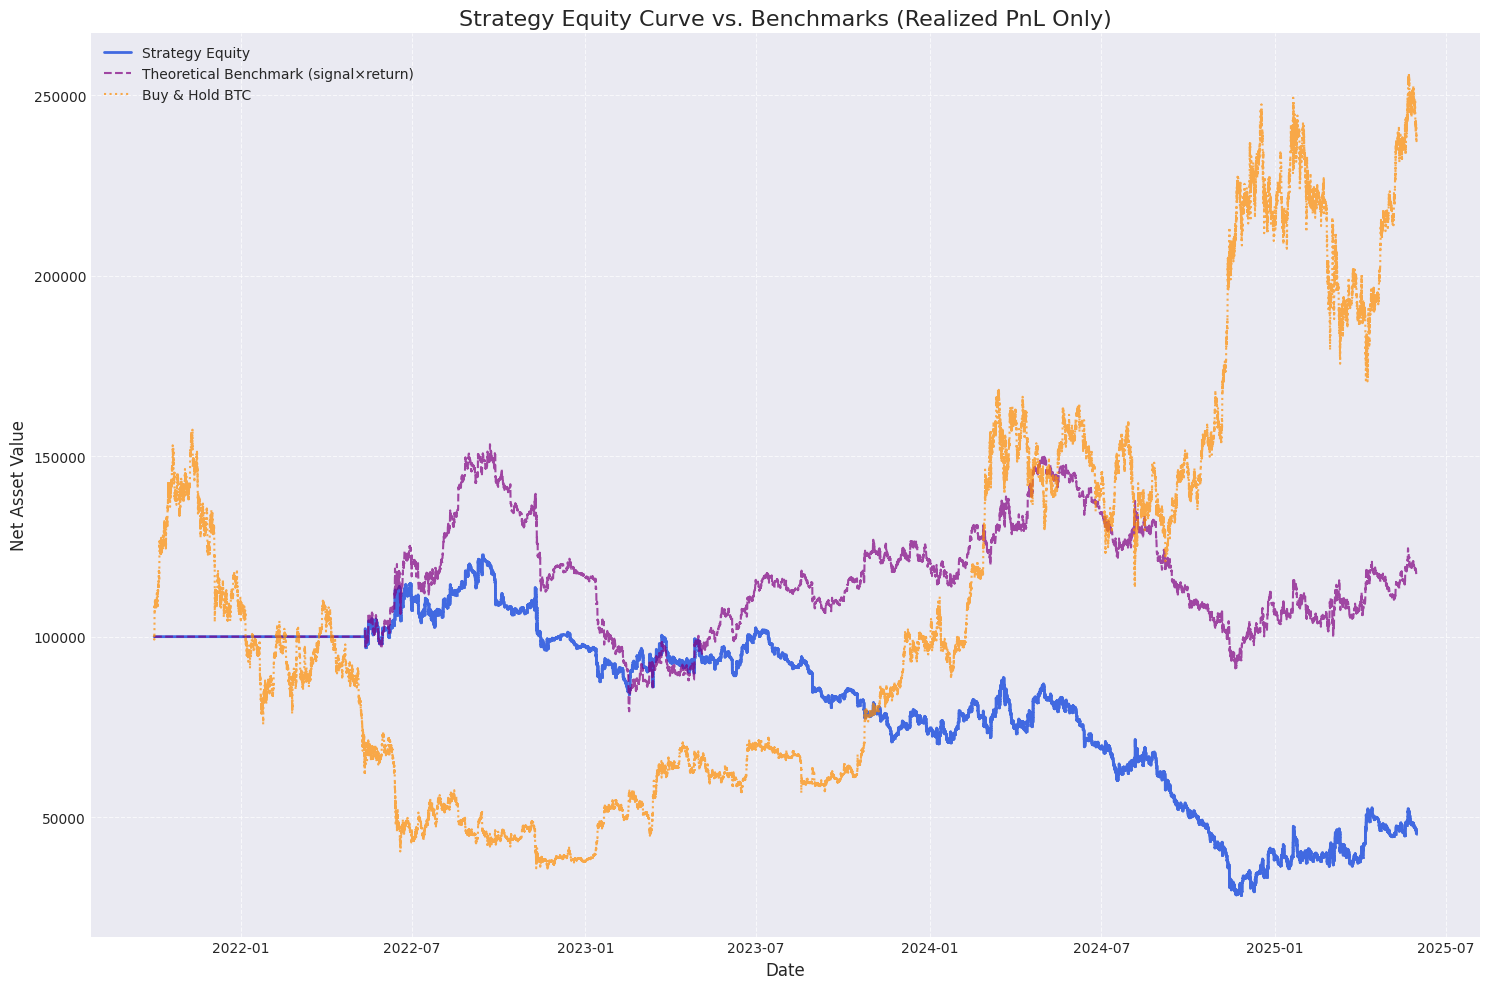

2025-08-08 00:23:11,252 - INFO - ✅ 策略评估报告生成完毕。


In [8]:
if __name__ == '__main__':
    # --- 0. 新增：CPU核心数配置 ---
    NUM_THREADS = 16
    tf.config.threading.set_intra_op_parallelism_threads(NUM_THREADS)
    tf.config.threading.set_inter_op_parallelism_threads(4)
    logging.info(f"🔧 TensorFlow已配置为使用最多 {NUM_THREADS} 个 intra-op 核心和 4 个 inter-op 核心。")

    # --- 1. 参数配置 ---
    FACTOR_FILE = '/public/data/factor_data/BTCUSDT_15m_2020_2025_factor_data.pkl'
    
    # 回测核心参数
    COMMISSION_RATE = 0.0002
    INITIAL_CAPITAL = 100000
    HOLDING_PERIOD = 10
    
    # ConvLSTM模型参数
    LOOKBACK_PERIOD = 60
    N_SPLITS = 5
    
    # 因子筛选参数
    MIN_IC = 0.01
    MIN_RANK_IC = 0.01

    # --- 2. 加载因子数据 ---
    logging.info(f"📂 从 {FACTOR_FILE} 加载因子数据...")
    
    try:
        with open(FACTOR_FILE, 'rb') as f:
            factor_data = pickle.load(f)
        
        # 确保索引是datetime类型
        factor_data.index = pd.to_datetime(factor_data.index)
        
        # 提取收盘价
        close_prices = factor_data['close'].copy()
        
        logging.info(f"✅ 数据加载成功 - 形状: {factor_data.shape}")
        logging.info(f"📅 时间范围: {factor_data.index[0]} 至 {factor_data.index[-1]}")
        logging.info(f"📈 特征总数量: {len(factor_data.columns)}")

    except Exception as e:
        logging.error(f"❌ 加载数据时发生错误: {e}")
        factor_data = None

    # --- 3. 因子筛选 ---
    if factor_data is not None:
        # 执行因子筛选
        selected_factors = filter_factors(
            factor_data, 
            close_prices,
            min_ic=MIN_IC,
            min_rank_ic=MIN_RANK_IC
        )
        
        # 如果筛选后因子数量不足，使用所有因子并发出警告
        if len(selected_factors) < 10:
            logging.warning(f"⚠️ 筛选后因子数量不足 ({len(selected_factors)}), 使用所有原始因子")
            selected_factors = [col for col in factor_data.columns 
                               if col.startswith('ret') or col.startswith('c_chu') or col.startswith('c_hide')]
        
        # --- 4. 准备滚动训练数据 ---
        X, y, indices, pca, selector = prepare_rolling_data(
            factor_data, 
            selected_factors,
            lookback=LOOKBACK_PERIOD
        )
        
        # --- 5. 执行滚动训练并生成信号 ---
        signals = rolling_train_and_predict(
            X, y, indices, 
            lookback=LOOKBACK_PERIOD, 
            n_splits=N_SPLITS
        )
        
        # --- 6. 创建与原始数据对齐的完整信号序列 ---
        full_signals = pd.Series(0, index=factor_data.index)
        full_signals.loc[signals.index] = signals
        
        # --- 7. 执行回测与评估 ---
        logging.info("✅ 信号生成完毕，直接进入回测与评估阶段...")
        
        try:
            backtest_results, trade_history = run_realized_pnl_backtest(
                prices=close_prices,
                signals=full_signals,
                initial_capital=INITIAL_CAPITAL,
                commission_rate=COMMISSION_RATE,
                holding_period=HOLDING_PERIOD
            )

            evaluate_realized_pnl_performance(
                backtest_results,
                trade_history,
                INITIAL_CAPITAL
            )
        except Exception as e:
            logging.error(f"❌ 在回测或评估过程中发生错误: {e}")

    else:
        logging.warning("⚠️ 由于数据加载失败，跳过模型训练、信号生成和回测步骤。")